<a href="https://colab.research.google.com/github/HuyenNguyenHelen/Emotion-_detection/blob/main/Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Expolatory Data Analysis

Importing the necessary libraries 

In [1]:
import gensim
import gensim.downloader as api
nlp = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import logging

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loading the dataset

In [33]:
# Downloading the csv file from your GitHub account

data_url1 = 'https://raw.githubusercontent.com/HuyenNguyenHelen/Emotion-_detection/main/2018.csv'
data_url2 = 'https://raw.githubusercontent.com/HuyenNguyenHelen/Emotion-_detection/main/2019.csv'
def loadFile (url):
  download = requests.get(url).content
  df = pd.read_csv(io.StringIO(download.decode('latin-1')))
  df.columns = ['time', 'studentID', 'Label', 'Sentence']
  print(df.shape)
  return  df #df[['Sentence', 'Label']]
df1 = loadFile (data_url1)
df2 = loadFile (data_url2)
df = pd.concat([df1,df2])
print(df.shape)
df

(16398, 4)
(12923, 4)
(29321, 4)


,time,studentID,Label,Sentence
0,8/30/2018 9:19,42,Option 4,Option 4
1,8/30/2018 9:20,63,Option 4,idk
2,8/30/2018 9:20,84,Fair,Because I forgot my glasses
3,8/30/2018 9:21,40,Option 4,Because schools boring
4,8/30/2018 9:21,45,Good,I missed Breakfast
...,...,...,...,...
12918,11/11/2019 15:06,160,Good,"Today was a completely average, normal day."
12919,11/12/2019 15:02,160,Good,I'm feeling this way because today was a compl...
12920,11/13/2019 15:02,160,Good,I'm feeling this way because today was a compl...
12921,10/9/2019 14:58,160,Good,I am feeling this way because I checked out a ...


# Exploration and Visualisation of the Dataset

In [34]:
#checking missing values
print('Before: \n', df.isnull().sum() )
df = df.dropna(subset = ['Sentence'])      
print('After: \n', df.isnull().sum() )


Before: 
 time          0
studentID     0
Label         0
Sentence     61
dtype: int64
After: 
 time         0
studentID    0
Label        0
Sentence     0
dtype: int64


In [35]:
# checking duplicate rows
print("number of duplicates before dropping: ", df[df.duplicated()].shape)

# Droping duplicates
df = df.drop_duplicates()
print("number of duplicates after dropping: ", df[df.duplicated()].shape)


number of duplicates before dropping:  (233, 4)
number of duplicates after dropping:  (0, 4)


In [36]:
print(df['Label'].value_counts())
print(round((df['Label'].value_counts()*100)/len(df['Label'])))


Good                              8736
Fair                              5384
Option 306                        5087
Excellent                         4979
Excellent!                        2437
Option 4                          2398
Not doing too hot Mr. Lovett!!       6
Name: Label, dtype: int64
Good                              30.0
Fair                              19.0
Option 306                        18.0
Excellent                         17.0
Excellent!                         8.0
Option 4                           8.0
Not doing too hot Mr. Lovett!!     0.0
Name: Label, dtype: float64


In [37]:
# # Droppping instances with Not doing too hot Mr. Lovett!!
# outliers = df[df.Label == 'Not doing too hot Mr. Lovett!!'].index
# df = df.drop(outliers)

df['Label'] = df['Label'].replace('Not doing too hot Mr. Lovett!!', 'Fair')
df['Label'] = df['Label'].replace('Excellent!', 'Excellent')
df['Label'] = df['Label'].replace('Option 306', 'Other')
df['Label'] = df['Label'].replace('Option 4', 'Other')

print(df['Label'].value_counts())
print(round((df['Label'].value_counts()*100)/len(df['Label'])))


Good         8736
Other        7485
Excellent    7416
Fair         5390
Name: Label, dtype: int64
Good         30.0
Other        26.0
Excellent    26.0
Fair         19.0
Name: Label, dtype: float64


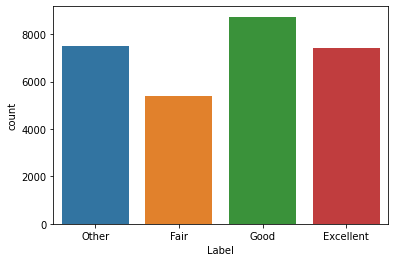

In [38]:
sns.countplot(x='Label', data=df)
plt.show()

# Data Pre-processing

## Cleaning test

In [21]:
!pip install stop-words
from stop_words import get_stop_words
stopwords = get_stop_words('en')
from textblob import Word
import re
import nltk
nltk.download('wordnet')

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=75be08b62df9134695dcbe7c1ff948ff30f4081833ebc9c7a028da72d520d5fc
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [39]:

def utils_preprocess_text(txt, lst_regex=None, punkt=True, lower=True, lst_stopwords=None, stemm=False, lemm=True):
    ## regex (in case, before processing)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt      
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]       
    ## Stemming 
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]         
    ## Lemmatization 
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ## remove leftover Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]     
    ## back to string from list
    txt = " ".join(lst_txt)
    return txt

In [40]:
df['text_clean'] = df['Sentence'].apply( lambda x:utils_preprocess_text(x, stemm = False, lemm = True, lst_stopwords=stopwords))
df.head()

,time,studentID,Label,Sentence,text_clean
0,8/30/2018 9:19,42,Other,Option 4,option 4
1,8/30/2018 9:20,63,Other,idk,idk
2,8/30/2018 9:20,84,Fair,Because I forgot my glasses,forgot glass
3,8/30/2018 9:21,40,Other,Because schools boring,school boring
4,8/30/2018 9:21,45,Good,I missed Breakfast,missed breakfast


## Encoding labels

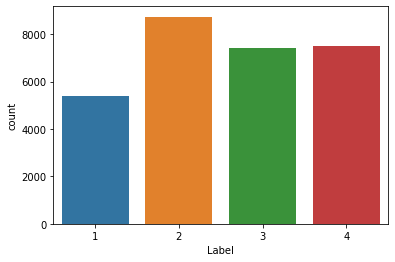

In [41]:
label_dic = {'Fair':1,
             'Good':2,
             'Excellent':3,
             'Other':4}
df['Label'] = df['Label'].map(label_dic)

sns.countplot(x='Label', data=df)
plt.show()

# Word2Vec Embedding

# Splitting Dataset for Training and Testing

In [42]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['text_clean']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())


Shapes of X_train, y_train:  (23221,) (23221,)
Shapes of X_test, y_test:  (5806,) (5806,)
2    6988
4    5988
3    5933
1    4312
Name: Label, dtype: int64


## Feature Extraction

In [43]:
# Using word2vec BOW to represent text
nlp.init_sims(replace=True) # calling for using syn0norm

# Tokenize, and apply word vector averaging to tokenized text
import nltk
nltk.download('punkt')
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
   

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
X_train_tokenized = X_train.apply(lambda x: w2v_tokenize_text(x)).values
X_test_tokenized = X_test.apply(lambda x: w2v_tokenize_text(x)).values

X_train_word_average = word_averaging_list(nlp,X_train_tokenized)
X_test_word_average = word_averaging_list(nlp,X_test_tokenized)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).


In [ ]:
## Oversampling

# # define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# X_train_word_average, y_train = oversample.fit_resample(X_train_word_average, y_train)
# print (y_train.shape)
# print(np.unique(y_train, return_counts=True))


## Model development

In [45]:
# Define a function for creating over sampling 
def score_model(model):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = True)

    oversampler = SMOTE(random_state=42)
    #oversampler = RandomOverSampler(sampling_strategy='minority')
    scores = []

    ## on training set, do cv
    for train_fold_index, val_fold_index in cv.split(X_train_word_average, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train_word_average[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_word_average[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = oversampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = accuracy_score(y_val_fold, model.predict(X_val_fold)) #  average= 'weighted' for F1
        scores.append(score)
    print('Average of acuracy score in training: %s' % np.array(scores).mean())

    ## on test set
    y_pred = model.predict(X_test_word_average)
    test_score = accuracy_score(y_pred, y_test)
    print('Average of acuracy in testing %s' % test_score)
    print(classification_report(y_test, y_pred))
    report_scores = {'accuracy_folds':np.array(scores),'accuracy_test':test_score, 'y_predicted':y_pred }
    return report_scores #(np.array(scores),test_score,y_pred )       #(np.array(scores).mean(), np.array(scores).std())


In [ ]:
# Running all models together
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=700)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(decision_function_shape='ovo', probability=True)))
# evaluate each model in turn
results = []
score_test = []
names = []
report_scores_all = []
for name, model in models:
  #fold_scores, test_score = score_model(model)
  report_scores = score_model(model)
  report_scores_all.append(report_scores)
  #results.append(fold_scores)
  #score_test.append(test_score)
  results.append(report_scores['accuracy_folds'])
  score_test.append(report_scores['accuracy_test'])
  names.append(name)
  # msg = "%s: %f (%f)" % (name, fold_scores.mean(), fold_scores.std())
  msg = "%s: %f (%f)" % (name, report_scores['accuracy_folds'].mean(), report_scores['accuracy_folds'].std())
  print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average of acuracy score in training: 0.5495888213694979
Average of acuracy in testing 0.5520151567344127
              precision    recall  f1-score   support

           1       0.44      0.50      0.47      1078
           2       0.60      0.52      0.56      1748
           3       0.56      0.62      0.59      1483
           4       0.60      0.56      0.58      1497

    accuracy                           0.55      5806
   macro avg       0.55      0.55      0.55      5806
weighted avg       0.56      0.55      0.55      5806

LR: 0.549589 (0.010234)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average of acuracy score in training: 0.5808967583647479
Average of acuracy in testing 0.5781949707199449
              precision    recall  f1-score   support

           1       0.50      0.48      0.49      1078
           2       0.64      0.54      0.59      1748
           3       0.57      0.66      0.61      1483
           4       0.59      0.61      0.60      1497

    accuracy                           0.58      5806
   macro avg       0.57      0.57      0.57      5806
weighted avg       0.58      0.58      0.58      5806

RF: 0.580897 (0.007253)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average of acuracy score in training: 0.5339563396851987
Average of acuracy in testing 0.527729934550465
              precision    recall  f1-score   support

           1       0.38      0.59      0.46      1078
           2       0.57      0.54      0.55      1748
           3       0.58      0.52      0.55      1483
           4       0.62      0.48      0.54      1497

    accuracy                           0.53      5806
   macro avg       0.54      0.53      0.53      5806
weighted avg       0.55      0.53      0.53      5806

KNN: 0.533956 (0.007104)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average of acuracy score in training: 0.4896857178134396
Average of acuracy in testing 0.4925938684119876
              precision    recall  f1-score   support

           1       0.37      0.47      0.42      1078
           2       0.55      0.50      0.52      1748
           3       0.51      0.50      0.50      1483
           4       0.53      0.49      0.51      1497

    accuracy                           0.49      5806
   macro avg       0.49      0.49      0.49      5806
weighted avg       0.50      0.49      0.50      5806

DT: 0.489686 (0.009193)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average of acuracy score in training: 0.46789567901852536
Average of acuracy in testing 0.4698587667929728
              precision    recall  f1-score   support

           1       0.37      0.39      0.38      1078
           2       0.52      0.45      0.48      1748
           3       0.47      0.46      0.46      1483
           4       0.50      0.56      0.53      1497

    accuracy                           0.47      5806
   macro avg       0.46      0.46      0.46      5806
weighted avg       0.47      0.47      0.47      5806

NB: 0.467896 (0.008060)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
